# Text Classification with the 20 Newsgroups Dataset

The *20 Newsgroups* dataset was created in the 1990s and contains texts extracted from various Usenet groups dedicated to specific topics. Its official homepage can be found here: http://qwone.com/~jason/20Newsgroups/

It is a commonly used dataset for benchmarking text classification approaches. Some examples of state-of-the-art benchmark scores on the dataset can be found here: https://paperswithcode.com/dataset/20-newsgroups

The labels of the dataset have been computed from the Usenet group where each message was posted. "Off-topic" messages therefore may have unintuitive or seemingly "wrong" labels.

## Download the Dataset

Run the following cell to download the CSV file containing the data. Note in this example we're downloading the data the "Pythonic" way, rather than using the Terminal command wget as in the previous notebook.

In [1]:
import requests

data_url = "https://raw.githubusercontent.com/TaylorPeer/bfh/main/PoML/data/20_newsgroups.csv"

response = requests.get(data_url)

# Check if the request was successful (status code 200)
if response.status_code == 200:
    
    # Save the file to your working directory
    with open("20_newsgroups.csv", "wb") as file:
        file.write(response.content)
    print("File downloaded successfully.")
    
else:
    print(f"Failed to download the file. Status code: {response.status_code}")


File downloaded successfully.


## Inspect the Dataset

As with the previous notebook, inspect the downloaded file to find out how to properly load it. Take note of its formatting.

In [2]:
!head -n 2 20_newsgroups.csv

text	newsgroup
 I am sure some bashers of Pens fans are pretty confused about the lack of any kind of posts about the recent Pens massacre of the Devils. Actually, I am bit puzzled too and a bit relieved. However, I am going to put an end to non-PIttsburghers' relief with a bit of praise for the Pens. Man, they are killing those Devils worse than I thought. Jagr just showed you why he is much better than his regular season stats. He is also a lot fo fun to watch in the playoffs. Bowman should let JAgr have a lot of fun in the next couple of games since the Pens are going to beat the pulp out of Jersey anyway. I was very disappointed not to see the Islanders lose the final regular season game. PENS RULE!!! 	rec.sport.hockey


## Load the Dataset

Use Pandas to load the dataset into a DataFrame.

In [3]:
import pandas as pd

df = pd.read_csv("20_newsgroups.csv", sep="\t")

## Inspect the Dataset

Make use of the .unique() function of a dataset to view all the unique values contained in a DataFrame column, in this case, the class labels.

In [4]:
df["newsgroup"].unique()

array(['rec.sport.hockey', 'comp.sys.ibm.pc.hardware',
       'talk.politics.mideast', 'comp.sys.mac.hardware',
       'sci.electronics', 'talk.religion.misc', 'sci.crypt', 'sci.med',
       'alt.atheism', 'rec.motorcycles', 'rec.autos', 'comp.windows.x',
       'comp.graphics', 'sci.space', 'talk.politics.guns', 'misc.forsale',
       'rec.sport.baseball', 'talk.politics.misc',
       'comp.os.ms-windows.misc', 'soc.religion.christian'], dtype=object)

### Label Distribution

Using the groupby() and count() methods, we can calculate the number of examples per class label.

Being aware of the underlying distribution of our data is important. Some learning algorithms may be affected by skewed data. Also, our interpretations of evaluation scores depends heavily on the distribution of the class labels as well as the number of classes.

In [5]:
df.groupby("newsgroup").count()

,text
newsgroup,
alt.atheism,778
comp.graphics,953
comp.os.ms-windows.misc,946
comp.sys.ibm.pc.hardware,962
comp.sys.mac.hardware,925
comp.windows.x,978
misc.forsale,957
rec.autos,931
rec.motorcycles,964


### Example Texts

Take a look at some of the raw data to get a feeling for the kinds of messages to be classified. Being familiar with the data can help with recognizing text that may be problematic for our classifiers later on.

In [6]:
# Increase the amount of text displayed when rendering DataFrames
pd.set_option('display.max_colwidth', 200)

df.sample(5)

,text,newsgroup
7601,"... I think this is a big leap sex->depression. One example is myself, where no sex->depression :) But, seriously 1) promiscuity is on a decline, depression is not and 2) it might be more reasona...",alt.atheism
2299,"Oh, why do you expose your ignorance? The US has been running on debt for the past four generations and has still financed what it pleases. And after the Gulf War, Israel could do whatever it wan...",talk.politics.mideast
13116,"How about a gun buy-back/charity? Get some sponsors to fund the purchase of used firearms, have a gunsmith check them over, and give or sell them at a low price to poor persons wishing to own fir...",talk.politics.guns
9322,I believe the interstates were origionally funded as part of a national defense plan etc. The requirements were to move heavy army trucks at 70mph. Still its amazing in Germany you can have cars t...,rec.autos
890,"Disaster! Finland was beaten by Czech 1-3 (0-0,1-1,0-2). Finland will be 4th of pool B and will most certainly meet Canada in the quarter final on wednesday 28th. Lack of scoring skills has been t...",rec.sport.hockey


## Vectorization

In the previous notebook using the Iris dataset, the raw features (petal and sepal widths and lengths) of the flowers to be classifed were already in a format that could be processed by machine learning algorithms so no explicit vectorization step was necessary. This is not the case when working with text data, and we will have to introduce a new explicit vectorization step. Even advanced text processing systems like ChatGPT do not work directly on text internally, but also use vector representations.

One way to vectorize text is to regard every word as a feature. In that case the length of our feature vector would equate to the number of unique words contained in our dataset. For each document in the dataset, we would then create a feature vector to represent it, with a 1 for every feature word contained in the document and a 0 for every other word present in the dataset but not contained in that particular document. 

As you can imagine, the feature vectors would be extremely large and mostly **sparse**, meaning they would mostly contain 0s, since most individual documents will not contain very many of the possible words. The size of these vectors presents a challenge for many learning algorithms and is often referred to as the **curse of dimensionality**.

Many **hyperparameters** are available that influence the size of these feature vectors to help keep them to a manageable size.


### TF-IDF

Rather than only using 1s and 0s to represent the presence and absense of feature terms, the concept of scoring the importance of terms has also been introduced. One way to compute scores for terms is via a TF-IDF calculation. TF-IDF combines two simple assumptions to assign scores to terms. The first assumption is that if a term appears frequently in a document, then it must be important in that document, e.g. the document is likely about that topic. The second assumption is that if a term appears frequently in the entire document collection, it is likely not that important, for instance, because it is a commonly used term overall. TF-IDF takes both of these assumptions into consideration and weights terms more highly for a document if they occur often in that document and weights them lower if they occur often overall in the collection.

### Feature Vectorization of Text Using TF-IDF

Run the following cell to vectorize the dataframe and inspect its new representation.

In [7]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Initialize the TF-IDF Vectorizer
tfidf_vectorizer = TfidfVectorizer()

# Fit and transform the 'Text' column
tfidf_matrix = tfidf_vectorizer.fit_transform(df['text'])

# Convert the TF-IDF matrix to a DataFrame
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=tfidf_vectorizer.get_feature_names_out())

tfidf_df

,00,000,0000,00000,000000,00000000,0000000004,00000000b,00000001,00000001b,...,zzs,zzvsi,zzy_3w,zzz,zzzoh,zzzzzz,zzzzzzt,³ation,ýé,ÿhooked
0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.217534,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18282,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
18283,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
18284,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
18285,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### TfidfVectorizer Hyperparameters

Use the *min_df* and *max_df* parameters of the TfidfVectorizer to adjust the vectorization of our dataframe. 

*min_df* represents the minimum amount of documents that must contain a term in order for it to be used as a feature in the vectorization process. This helps us set a sensible lower cutoff to avoid vectorizing typos, spelling mistakes, and other uncommon words that are unlikely to be useful during training.

*max_df* represents the maximum amount of documents that can contain a term in order for it to be used as a feature in the vectorization process. This helps us sort out extremely frequent terms that are unlikely to give us any hints about the class label of a document.

Note that both parameters accept both floating point values between 0 and 1 to represent a percentage of the document collection as well as an integer value representing an absolute number of documents in the collection.

In [23]:
tfidf_vectorizer = TfidfVectorizer(max_df=0.3, min_df=0.04)

tfidf_matrix = tfidf_vectorizer.fit_transform(df['text'])
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=tfidf_vectorizer.get_feature_names_out())
tfidf_df

,10,15,20,able,about,above,actually,after,again,against,...,won,work,world,would,wrong,year,years,yes,yet,your
0,0.000000,0.000000,0.000000,0.000000,0.172146,0.000000,0.14182,0.0,0.000000,0.000000,...,0.000000,0.00000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000
1,0.000000,0.000000,0.000000,0.186971,0.000000,0.000000,0.00000,0.0,0.000000,0.000000,...,0.000000,0.00000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.123660
2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.0,0.000000,0.000000,...,0.000000,0.00000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000
3,0.118063,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.0,0.000000,0.000000,...,0.129067,0.00000,0.120444,0.070314,0.251377,0.0,0.0,0.000000,0.0,0.000000
4,0.361753,0.395707,0.387493,0.000000,0.000000,0.000000,0.00000,0.0,0.179475,0.000000,...,0.000000,0.00000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18282,0.000000,0.000000,0.000000,0.000000,0.000000,0.068311,0.00000,0.0,0.000000,0.000000,...,0.000000,0.00000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.175113
18283,0.000000,0.000000,0.000000,0.145028,0.169762,0.000000,0.00000,0.0,0.000000,0.000000,...,0.000000,0.00000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.095919
18284,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.0,0.000000,0.000000,...,0.000000,0.00000,0.000000,0.000000,0.000000,0.0,0.0,0.243148,0.0,0.158147
18285,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.0,0.000000,0.000000,...,0.062720,0.05153,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.039285


## Training

Before training, let's divide our dataset into training and test splits.

In [9]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

X_train, X_test, y_train, y_test = train_test_split(df["text"], df["newsgroup"], test_size=0.2)

classifier = LogisticRegression()

### Fit the Vectorizer only on the Training Set

It's important to fit the vectorizer only on the training set and not the entire dataset - why?

In [10]:
tfidf_vectorizer = TfidfVectorizer(max_df=0.8, min_df=20)
tfidf_matrix = tfidf_vectorizer.fit_transform(X_train)

### Apply the Fitted Vectorizer to the Test Set

In [11]:
tf_idf_vectorized_test = tfidf_vectorizer.transform(X_test)

### Train the Model

In [12]:
trained_model = classifier.fit(tfidf_matrix, y_train)

/Users/taylor/bfh/bfh/bfh-env/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


### Evaluate the Model

In [13]:
from sklearn.metrics import classification_report

predictions = trained_model.predict(tf_idf_vectorized_test)

print(classification_report(
    y_test, 
    predictions, 
    target_names=trained_model.classes_))


                          precision    recall  f1-score   support

             alt.atheism       0.57      0.55      0.56       161
           comp.graphics       0.61      0.68      0.64       171
 comp.os.ms-windows.misc       0.66      0.73      0.70       179
comp.sys.ibm.pc.hardware       0.72      0.64      0.68       185
   comp.sys.mac.hardware       0.73      0.70      0.72       176
          comp.windows.x       0.85      0.78      0.81       214
            misc.forsale       0.78      0.78      0.78       188
               rec.autos       0.73      0.64      0.68       178
         rec.motorcycles       0.65      0.80      0.72       203
      rec.sport.baseball       0.81      0.84      0.82       204
        rec.sport.hockey       0.90      0.86      0.88       214
               sci.crypt       0.84      0.78      0.81       193
         sci.electronics       0.61      0.69      0.65       195
                 sci.med       0.78      0.82      0.80       187
         

### Confusion Matrix

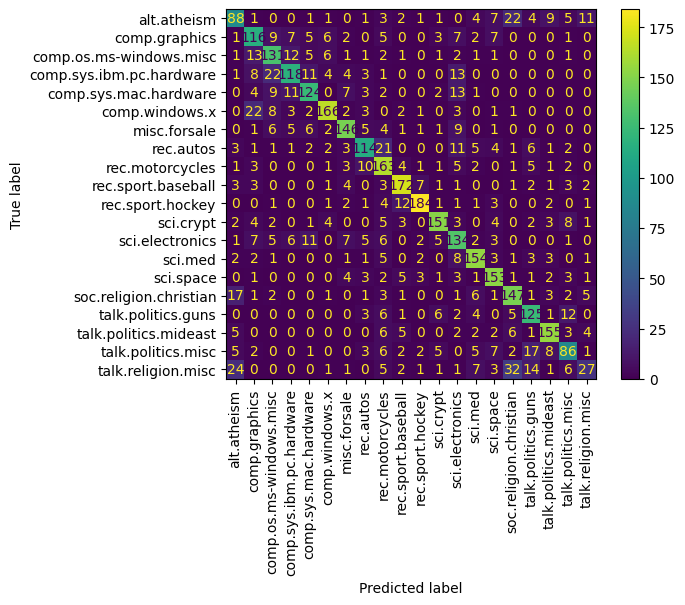

In [14]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_test, predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=trained_model.classes_)
disp.plot(xticks_rotation="vertical")
plt.show()


### Additional Models

Adjust the hyperparameters of the following classifiers and TfidfVectorizer to investigate their impact on the runtime and performance of the models. 

Some models used in the previous Iris notebook have been excluded here due to their extremely slow performance on large feature vectors (KNeighborsClassifier and SVC).

In [15]:
import time
from tqdm import tqdm
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier

from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier

# Decision Tree:
# - max_depth: maximum depth of decision nodes (default: None)
decision_tree = DecisionTreeClassifier(max_depth=10)

# Random Forest
# - n_estimators: number of individual decision trees used internally by the model (default: 100)
random_forest = RandomForestClassifier(n_estimators=50)

# Naive Bayes:
naive_bayes = MultinomialNB()

# Logistic Regression:
# - max_iter: maximum number of iterations (default: 100)
logistic_regression = LogisticRegression(max_iter=1000)

classifiers = [
    decision_tree,
    random_forest,
    naive_bayes,
    logistic_regression
]

tfidf_vectorizer = TfidfVectorizer(max_df=0.8, min_df=20)
tfidf_matrix = tfidf_vectorizer.fit_transform(X_train)
tf_idf_vectorized_test = tfidf_vectorizer.transform(X_test)

model_metrics = []
for classifier in tqdm(classifiers):
    
    # Train the classifier
    start_time = time.time()
    trained_model = classifier.fit(tfidf_matrix, y_train)
    end_training_time = time.time()
    training_time_elapsed = end_training_time - start_time
    
    # Apply trained classifier to test set
    start_time = time.time()
    predictions = trained_model.predict(tf_idf_vectorized_test)
    prediction_time = time.time()
    prediction_time_elapsed = prediction_time - start_time
    
    # Measure model performance
    score = classifier.score(tf_idf_vectorized_test, y_test)
    
    # Record model metrics
    model_metrics.append({
        "model": trained_model.__class__.__name__,
        "training_time": training_time_elapsed,
        "prediction_time": prediction_time_elapsed,
        "score": score,
    })
    
# Print model metrics table
pd.DataFrame(model_metrics)

100%|██████████| 4/4 [00:31<00:00,  7.96s/it]


,model,training_time,prediction_time,score
0,DecisionTreeClassifier,2.019471,0.007400,0.225260
1,RandomForestClassifier,22.586475,0.130417,0.635867
2,MultinomialNB,0.064873,0.003921,0.710498
3,LogisticRegression,6.860633,0.005668,0.725533


### Impact of Training Set Size

Since our TfidfVectorizer is "trained" on the training set, it only knows words contained in that collection. If this set is very small, our vectorizer will not know many terms and other, new documents to be classified will contain many **out-of-vocabulary** terms. This is an instance where having more data available to train with typically drastically improves model performance - to a point.

Run the cell below to view the impact of training on different amounts of data.

In [16]:
# Naive Bayes:
naive_bayes = MultinomialNB()

training_set_sizes = [0.05, 0.1, 0.2, 0.3, 0.4, 0.6, 0.8, 1.0]

model_metrics = []
for training_set_size in tqdm(training_set_sizes):
    
    X_train_sample = X_train.sample(frac=training_set_size).sort_index()
    y_train_sample = y_train[y_train.index.isin(X_train_sample.index)].sort_index()
    
    tfidf_vectorizer = TfidfVectorizer(max_df=0.8, min_df=20)
    tfidf_matrix = tfidf_vectorizer.fit_transform(X_train_sample)
    tf_idf_vectorized_test = tfidf_vectorizer.transform(X_test)
    
    # Train the classifier
    start_time = time.time()
    trained_model = classifier.fit(tfidf_matrix, y_train_sample)
    end_training_time = time.time()
    training_time_elapsed = end_training_time - start_time
    
    # Apply trained classifier to test set
    predictions = trained_model.predict(tf_idf_vectorized_test)
    
    # Measure model performance
    score = classifier.score(tf_idf_vectorized_test, y_test)
    
    # Record model metrics
    model_metrics.append({
        "training_set_proportion": training_set_size,
        "training_set_size": len(X_train_sample),
        "training_time": training_time_elapsed,
        "score": score,
    })
    
# Print model metrics table
pd.DataFrame(model_metrics)

100%|██████████| 8/8 [00:31<00:00,  3.92s/it]


,training_set_proportion,training_set_size,training_time,score
0,0.05,731,0.064726,0.296610
1,0.10,1463,0.224187,0.436577
2,0.20,2926,0.798066,0.557955
3,0.30,4389,1.260809,0.626572
4,0.40,5852,1.887546,0.659103
5,0.60,8777,3.587124,0.686167
6,0.80,11703,5.371195,0.714051
7,1.00,14629,7.431531,0.725533


### Explainability

Different models have different internal workings. In the previous Iris notebook we saw how to inspect a Decision Tree classifier to interpret how it classifies our data. Other models have other ways of interpreting their output. 

Regression models work by learning weights to associate with each feature. These weights are then multiplied with the feature value during prediction time and an internal calculation is used to predict a class label. The value of these weights can be interpreted as a kind of "importance" since a higher weight will cause an input feature to indicate in favor of or against a particular class label.

The feature weights of our trained Logistic Regression model can be inspected as follows:

In [17]:
# Fit our vectorizer and logistic regression model
tfidf_vectorizer = TfidfVectorizer(max_df=0.8, min_df=20)
tfidf_matrix = tfidf_vectorizer.fit_transform(X_train)
logistic_regression = LogisticRegression(max_iter=1000)
logistic_regression = logistic_regression.fit(tfidf_matrix, y_train)

# Get the coefficients from the trained model
coefficients = logistic_regression.coef_[0]

tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=tfidf_vectorizer.get_feature_names_out())
feature_names = tfidf_df.columns

# Create a DataFrame to display the coefficients with feature names
coefficients_df = pd.DataFrame({'Feature': feature_names, 'Coefficient': coefficients})

# Sort the DataFrame by the absolute magnitude of coefficients
coefficients_df['Abs_Coefficient'] = abs(coefficients_df['Coefficient'])
sorted_coefficients_df = coefficients_df.sort_values(by='Abs_Coefficient', ascending=False)

# Display the sorted DataFrame to see the most important features
sorted_coefficients_df.head(20)

,Feature,Coefficient,Abs_Coefficient
3123,god,3.688615,3.688615
5711,religion,3.537908,3.537908
818,atheism,3.509497,3.509497
3757,islam,3.287123,3.287123
820,atheists,3.280457,3.280457
819,atheist,3.172589,3.172589
1102,bobby,2.867981,2.867981
3758,islamic,2.670169,2.670169
1038,bible,2.376562,2.376562
3876,kent,2.147412,2.147412
